## About Dataset fer2013 used from Emotion detection
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt

### VGG 19

VGG19 is a convolutional neural network model known for its depth, consisting of 19 layers, and it's commonly used for image recognition tasks. It was trained on the ImageNet dataset and is popular for both classification and feature extraction in deep learning applications.

Here the steps we followed:
1. Initialize VGG19 Model
2. Define Model Output
3. Load and Process Image
4. Process Image from Array 
5. Deprocess Image 
6. Capture Image from Webcam
7. Display Image 
8. Define Content and Style Layers
9. Initialize Content and Style Models
10. Define Content Loss Function
11. Define Gram Matrix Function
12. Define Style Loss Function
13. Set Loss Weights
14. Compute Total Loss Function
15. Capture and Display Image from Webcam

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

def get_model_output(model, layers):
    outputs = [model.get_layer(layer).output for layer in layers]
    return Model([model.input], outputs)

def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def process_image_from_array(img_array):
    img = cv2.resize(img_array, (224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((224, 224, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def capture_image_from_webcam():
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    cap.release()
    if ret:
        cv2.imwrite('/mnt/data/captured_image.png', frame)
        return frame
    else:
        raise Exception("Failed to capture image from webcam")

def display_image(image_array):
    plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

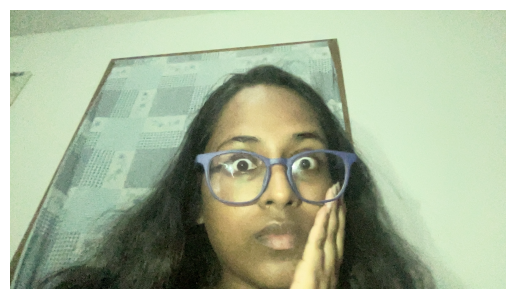

In [1]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_model = get_model_output(vgg, content_layers)
style_model = get_model_output(vgg, style_layers)

def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    return tf.reduce_mean(tf.square(S - G))

content_weight = 1e3
style_weight = 1e-2

def compute_loss(content_image, style_image, generated_image):
    content_output = content_model(content_image)
    generated_content_output = content_model(generated_image)
    content_loss_val = content_loss(content_output, generated_content_output)
    
    style_outputs = style_model(style_image)
    generated_style_outputs = style_model(generated_image)
    style_loss_val = sum([style_loss(style, gen) for style, gen in zip(style_outputs, generated_style_outputs)])
    
    total_loss = content_weight * content_loss_val + style_weight * style_loss_val
    return total_loss

#capture the image from the webcam
captured_image = capture_image_from_webcam()
display_image(captured_image)

In [2]:
from PIL import Image
def save_image_as_pil(image, filename):
    #convert the image from BGR (OpenCV) to RGB (PIL)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)
    pil_image.save(filename)
save_image_as_pil(captured_image, 'captured_image.jpg')

In [44]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn

### Used the pretrained emotion detection model to detect emotions of captured images

/Users/shreshtagundoju/anaconda3/envs/cse573/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shreshtagundoju/anaconda3/envs/cse573/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/5p/j088zcbj0zdfl8nxkck66jlw0000gn/T/ipykernel_41401/4004514658.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more deta

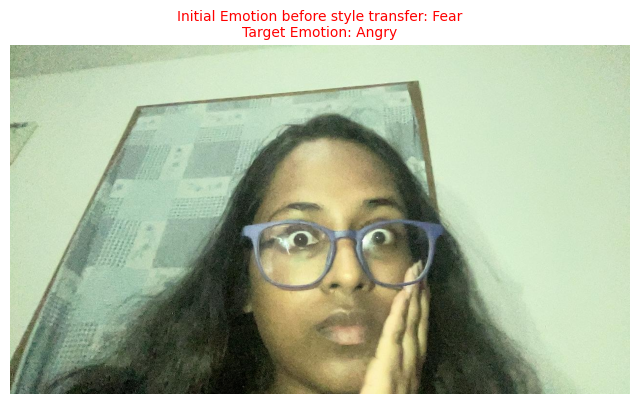

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 7)
model.load_state_dict(torch.load('emotion_model_15.pth'))
model.eval()

emotion_classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
target_emotion = input("Enter the target emotion from: 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'): ").capitalize()
if target_emotion not in emotion_classes:
    raise ValueError(f"Invalid emotion. Please choose from: {', '.join(emotion_classes)}")

image_path = 'captured_image.jpg'
image = Image.open(image_path)
image_transformed = transform(image)
image_transformed = image_transformed.unsqueeze(0)
with torch.no_grad():
    outputs = model(image_transformed)
    _, predicted = torch.max(outputs.data, 1)
    predicted_emotion = emotion_classes[predicted.item()]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Initial Emotion before style transfer: {predicted_emotion}\nTarget Emotion: {target_emotion}', fontsize=10, color='red')
plt.axis('off')
plt.show() 

### Applied Style Transfer on the Captured Image

Epoch 0: Loss: 4713946112.0


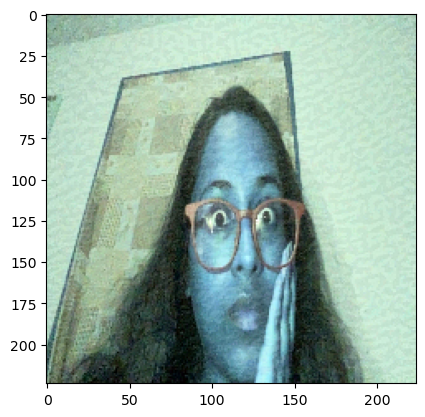

Epoch 50: Loss: 38336660.0


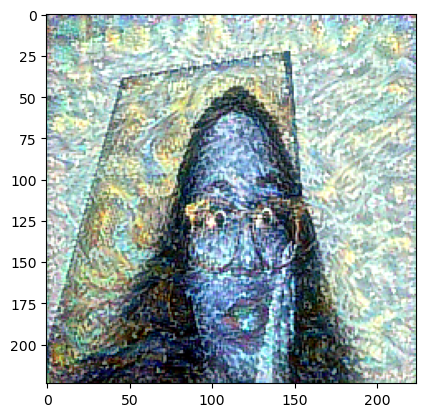

In [4]:
content_image = process_image_from_array(captured_image)
style_image = load_and_process_image("Starry-Night.png")
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def train_step(content_image, style_image, generated_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_image, style_image, generated_image)
    gradient = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradient, generated_image)])
    return loss

epochs = 100
patience = 30
best_loss = float('inf')
wait = 0
losses = []

for epoch in range(epochs):
    loss = train_step(content_image, style_image, generated_image)
    loss_value = loss.numpy()
    losses.append(loss_value)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss: {loss_value}")
        plt.imshow(deprocess_image(generated_image.numpy()))
        plt.show()
    if loss_value < best_loss:
        best_loss = loss_value
        wait = 0
        generated_image_np = generated_image.numpy()
        np.save("best_generated_image.npy", generated_image_np)
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch} with best loss {best_loss}")
            break

In [6]:
final_image = deprocess_image(generated_image.numpy())

In [7]:
cv2.imshow("Final Generated Image", final_image)
webcam = cv2.VideoCapture(0)
cv2.waitKey(0)
cv2.destroyAllWindows() 

In [8]:
ret, captured_image_2 = webcam.read()

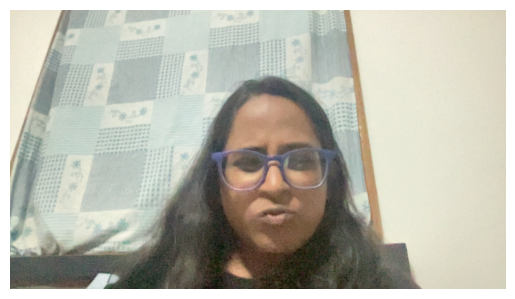

In [9]:
display_image(captured_image_2)
save_image_as_pil(captured_image_2, 'captured_image_2.jpg')

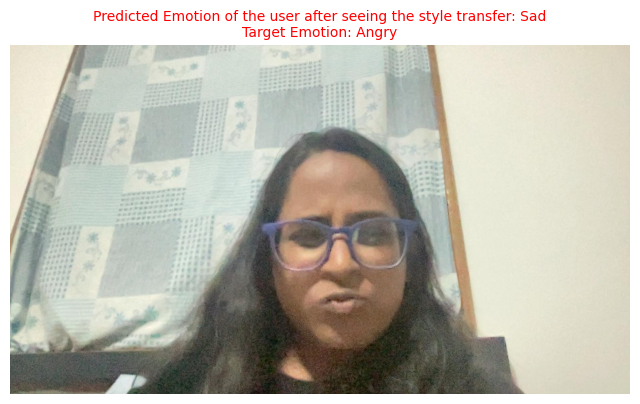

The emotion of the captured image is: Sad
Target emotion provided: Angry


In [32]:
# Load and preprocess the captured image
image_path = 'captured_image_2.jpg'
image = Image.open(image_path)

# Predict the emotion
image_transformed = transform(image)
image_transformed = image_transformed.unsqueeze(0)
with torch.no_grad():
    outputs = model(image_transformed)
    _, predicted = torch.max(outputs.data, 1)
    predicted_emotion_2 = emotion_classes[predicted.item()]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.title(f'Predicted Emotion of the user after seeing the style transfer: {predicted_emotion_2}\nTarget Emotion: {target_emotion}', fontsize=10, color='red')
plt.axis('off')
plt.show()
print(f'The emotion of the captured image is: {predicted_emotion_2}')
print(f'Target emotion provided: {target_emotion}')

In [33]:
webcam.release()
cv2.destroyAllWindows()

### Style Parameter Update
1. If the emotion change is positive (increasing towards the target emo-
tion), update the style parameters in the same direction.
2. If the emotion change is negative, update the style parameters in the opposite direction.
3. The magnitude of the update is determined by num of steps.

In [42]:
# Process the captured image
content_image = process_image_from_array(captured_image)
style_image = load_and_process_image("Starry-Night.png")

generated_image_final = tf.Variable(content_image, dtype=tf.float32)

optimizer = tf.optimizers.Adam(learning_rate=5.0)

@tf.function()
def train_step(content_image, style_image, generated_image_final):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_image, style_image, generated_image_final)
    gradient = tape.gradient(loss, generated_image_final)
    optimizer.apply_gradients([(gradient, generated_image_final)])
    return loss

The emotion of the captured image is: Sad
Target emotion provided: Angry
Emotion change: 4
Emotion change is positive. Increasing the number of steps.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0: Loss: 4713946112.0


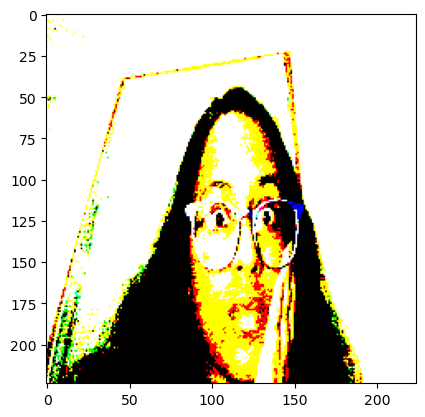

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50: Loss: 38336660.0


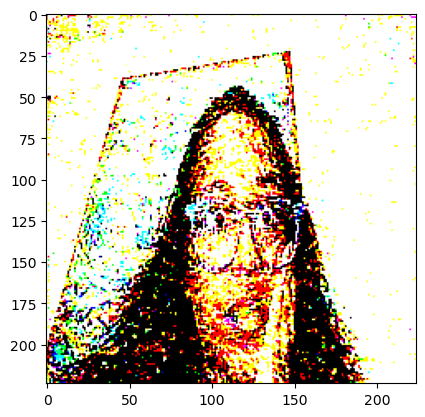

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100: Loss: 20472294.0


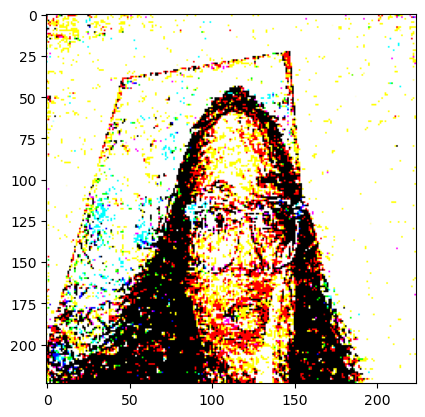

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 150: Loss: 15490126.0


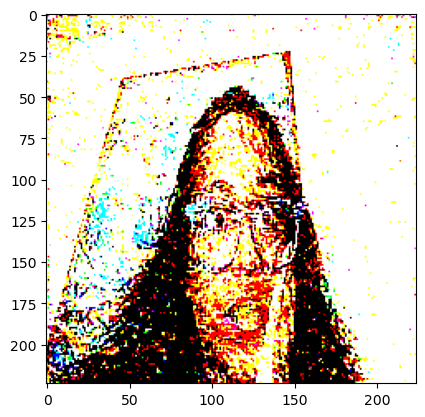

In [43]:
#calculate emotion change
emotion_change = emotion_classes.index(predicted_emotion_2) - emotion_classes.index(target_emotion)
print(f'The emotion of the captured image is: {predicted_emotion_2}')
print(f'Target emotion provided: {target_emotion}')
print(f'Emotion change: {emotion_change}')

#adjust number of steps based on emotion change
if emotion_change < 0:
    print("Emotion change is negative. Reducing the number of steps.")
    epochs = 50
else:
    print("Emotion change is positive. Increasing the number of steps.")
    epochs = 200
    
patience = 30
best_loss = float('inf')
wait = 0
losses = []

for epoch in range(epochs):
    loss = train_step(content_image, style_image, generated_image_final)
    loss_value = loss.numpy()
    losses.append(loss_value)
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss: {loss_value}")
        plt.imshow(np.squeeze(generated_image_final.numpy()))
        plt.show()
        
    if loss_value < best_loss:
        best_loss = loss_value
        wait = 0
        #save the best model
        generated_image_np = generated_image.numpy()
        np.save("best_generated_image_converged.npy", generated_image_np)
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch} with best loss {best_loss}")
            break